<a href="https://colab.research.google.com/github/dwoolworth/tensorflow-stock-prediction/blob/main/tensorflow_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Using artificial recurrent neural network (RNN) called Long Short-Term Memory
# (LSTM) to predict the closing stock price of a corporation using the past
# X days' stock price.
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('max_rows', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('min_rows', 30)
pd.set_option('max_columns', None)
pd.set_option('display.max_columns', None)

# Analyzing big companies like IBM or ATT, etc. this model will have good,
# predictable results. Those entities are not in the media, not typically
# suceptible to things other than the economy or factors that impact all stocks.
# AI is great with predictable patterns.  So we need to work on predicting/
# foretelling smaller companies with potential more volatility given other
# outside factors such as news, politics, etc.

stock_ticker = 'STM'

start_date = '2017-01-01'
end_date = '2021-04-01'

# Play with training days because this is where potentially shorter intervals
# may yield better predictions.
training_days = 60

# Another factor to adjust given the amount of data available for the stock,
# we'll default to 80% of data to train with, 20% of data to test with
percent_of_data_to_train = .90


In [3]:
# Get the stock quote
df = web.DataReader(stock_ticker, data_source='yahoo', start=start_date, end=end_date)
# Get the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,11.160000,10.850000,11.150000,10.980000,3119500.0,10.476607
2017-01-04,10.940000,10.770000,10.770000,10.880000,3756200.0,10.381189
2017-01-05,11.110000,10.910000,10.920000,10.940000,2395900.0,10.438438
2017-01-06,10.820000,10.670000,10.730000,10.790000,3057800.0,10.295317
2017-01-09,11.220000,10.990000,10.990000,11.150000,3582800.0,10.638809
2017-01-10,11.380000,11.220000,11.220000,11.290000,2198000.0,10.772392
2017-01-11,11.470000,11.280000,11.320000,11.460000,2163700.0,10.934600
2017-01-12,11.410000,11.290000,11.320000,11.400000,2451900.0,10.877349
2017-01-13,11.670000,11.530000,11.540000,11.630000,1899100.0,11.096806


In [4]:
df.shape

(1069, 6)

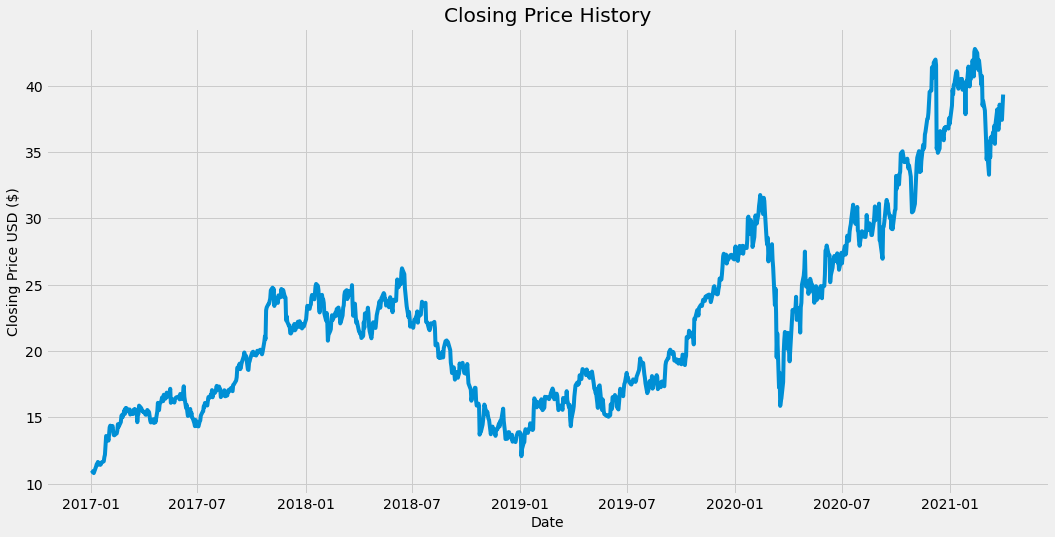

In [5]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price USD ($)', fontsize=14)
plt.show()

In [6]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * percent_of_data_to_train)

training_data_len

963

In [7]:
# Scale the data so that each data point is a value between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00593749],
       [0.0028125 ],
       [0.00468749],
       ...,
       [0.83281243],
       [0.86062503],
       [0.89249993]])

In [8]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
days_training = training_days
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(days_training, len(train_data)):
  x_train.append(train_data[i-days_training:i, 0])
  y_train.append(train_data[i, 0])
  if i <= (days_training + 1):
    print(x_train)
    print(y_train)
    print()


[array([0.00593749, 0.0028125 , 0.00468749, 0.        , 0.01124999,
       0.015625  , 0.0209375 , 0.01906249, 0.02625   , 0.019375  ,
       0.02062499, 0.02500001, 0.02562499, 0.02781251, 0.03749999,
       0.04343751, 0.06687501, 0.0875    , 0.0834375 , 0.07656249,
       0.09062499, 0.10781249, 0.11187499, 0.10843751, 0.1109375 ,
       0.09843749, 0.08968749, 0.08906251, 0.09281251, 0.09343749,
       0.09999999, 0.11531248, 0.10843751, 0.12031251, 0.13499999,
       0.13718751, 0.1315625 , 0.14812499, 0.1396875 , 0.15312498,
       0.14968749, 0.15281251, 0.14500001, 0.14437499, 0.15      ,
       0.138125  , 0.1396875 , 0.139375  , 0.139375  , 0.14968749,
       0.14906251, 0.15093749, 0.1446875 , 0.12      , 0.136875  ,
       0.139375  , 0.1590625 , 0.15437498, 0.15218749, 0.14812499])]
[0.1453124837484216]

[array([0.00593749, 0.0028125 , 0.00468749, 0.        , 0.01124999,
       0.015625  , 0.0209375 , 0.01906249, 0.02625   , 0.019375  ,
       0.02062499, 0.02500001, 0.025

In [9]:
# Convert the x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the data (LSTM model is expecting 3 dimensional data)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(903, 60, 1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

903/903 [==============================] - 27s 26ms/step - loss: 0.0049


In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - days_training: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(days_training, len(test_data)):
  x_test.append(test_data[i-days_training:i, 0])
  

In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the data (need it to be 3 dimensional)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Get the models predicted price values
predictions = model.predict(x_test)
# Unscale the values
predictions = scaler.inverse_transform(predictions)
# So we're wanting predictions to contain the same values as y_test dataset

In [18]:
# Get the root mean squared error (RMSE)
# ...evaluating performance of model based on standard deviation
rmse = np.sqrt(np.mean(((predictions - y_test )**2)))
# A value of 0.0 means that the values matched up perfectly.
# A value between 1.0 and 5.0 is still 'ok', but obviously, a more
# accurate value is better here.  Our results are as follows:
rmse

1.7018494522766556

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


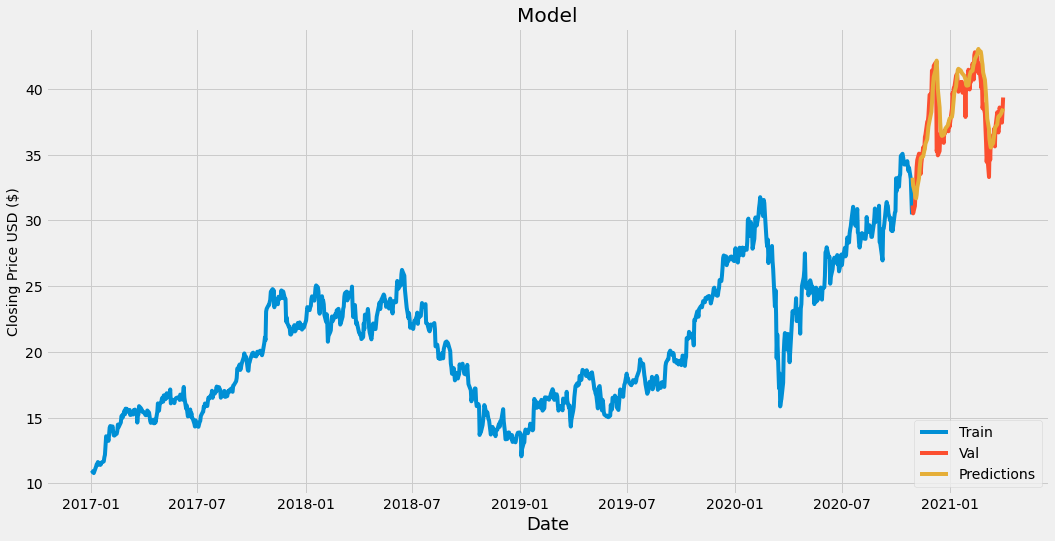

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-10-29,31.139999,33.247456
2020-10-30,30.540001,32.647324
2020-11-02,31.100000,32.087536
2020-11-03,32.150002,31.726259
2020-11-04,33.040001,31.684692
2020-11-05,34.070000,31.954290
2020-11-06,34.590000,32.509232
2020-11-09,35.080002,33.213009
2020-11-10,33.509998,33.966908


In [42]:
# Get the quote
ticker_quote = web.DataReader(stock_ticker, data_source='yahoo', start=start_date, end=end_date)
new_df = ticker_quote.filter(['Close'])
# Get the last X day closing price values and convert the dataframe to an array
last_X_days = new_df[-training_days:].values
# Scale the data to be values bewteen 0 and 1
last_X_days_scaled = scaler.transform(last_X_days)
# Create an empty list
X_test = []
# Append the past X days
X_test.append(last_X_days_scaled)
X_test1 = np.array(X_test)
# Reshape the data to be 3 dimensional
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

In [41]:
#X_predictions = []
#for i in range(30):
  # Get the predicted price (scaled) from numpy.array()
#  pred_price = model.predict(X_test1)
#  print(X_test1.shape)
  # Append the predicted price onto the end
  # X_test = []
  # Append the past X days
#  last_X_days_scaled
#  X_test.append(pred_price)
#  print(X_test)
#  X_test1 = np.array(X_test)
#  X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))
  # Undo the scaling
#  X_predictions.append(scaler.inverse_transform(pred_price))

#print(X_predictions)

(1, 60, 1)


AttributeError: ignored

In [43]:
ticker_quote2 = web.DataReader(stock_ticker, data_source='yahoo', start=end_date, end=end_date)
ticker_quote2['Close']

Date
2021-04-01    39.349998
2021-04-01    39.349998
Name: Close, dtype: float64